<a href="https://colab.research.google.com/github/SuwethaV/Medmnist/blob/main/FinalReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ----------------------------------------
# STEP 1 — INSTALL & IMPORT DEPENDENCIES
# ----------------------------------------

!pip install medmnist torch torchvision tqdm matplotlib scikit-learn fire --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms
import os
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
# ----------------------------------------
# STEP 2 — DEVICE, HYPERPARAMETERS, DATA LOADING (Fixed)
# ----------------------------------------

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[Step 1] Using device:", device)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 5
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

dataset_flag = "pathmnist"
info = INFO[dataset_flag]
DataClass = getattr(medmnist, info["python_class"])

# Transform
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load datasets
train_dataset = DataClass(split="train", transform=data_transform, download=True, as_rgb=True)
val_dataset = DataClass(split="val", transform=data_transform, download=True, as_rgb=True)
test_dataset = DataClass(split="test", transform=data_transform, download=True, as_rgb=True)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(info["label"])

print("Data loaded successfully!")
print(f"Dataset: {dataset_flag} | Number of classes: {num_classes}")

# Class labels
if isinstance(info['label'], dict):
    label_names = [info['label'][i] for i in sorted(info['label'].keys())]
elif isinstance(info['label'], list):
    label_names = info['label']
else:
    label_names = list(info['label'].values())

print("Class Labels:", label_names)


[Step 1] Using device: cpu


100%|██████████| 206M/206M [03:08<00:00, 1.09MB/s]


Data loaded successfully!
Dataset: pathmnist | Number of classes: 9
Class Labels: ['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium']


In [ ]:
# ----------------------------------------
# STEP 3 — CHANNEL & SPATIAL ATTENTION BLOCKS
# ----------------------------------------

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        hidden = max(4, in_planes // ratio)
        self.fc1 = nn.Conv2d(in_planes, hidden, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(hidden, in_planes, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        return self.sigmoid(avg_out + max_out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attn = self.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))
        return x * attn


In [ ]:
# ----------------------------------------
# STEP 4 — MODEL ARCHITECTURE
# ----------------------------------------

class MultiScaleDualAttentionCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiScaleDualAttentionCNN, self).__init__()
        # Multi-scale convolution layers
        self.conv3 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(3, 32, kernel_size=7, padding=3)

        self.bn = nn.BatchNorm2d(96)
        self.relu = nn.ReLU(inplace=True)

        # Dual attention
        self.ca = ChannelAttention(96, ratio=8)
        self.sa = SpatialAttention(kernel_size=7)

        # Pooling & fully connected head
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(96, num_classes)

    def forward(self, x):
        f3 = self.conv3(x)
        f5 = self.conv5(x)
        f7 = self.conv7(x)
        x = torch.cat([f3, f5, f7], dim=1)
        x = self.relu(self.bn(x))
        x = x * self.ca(x)
        x = self.sa(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)


model = MultiScaleDualAttentionCNN(num_classes).to(device)
print(model)


MultiScaleDualAttentionCNN(
  (conv3): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv7): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (ca): ChannelAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (fc1): Conv2d(96, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
    (fc2): Conv2d(12, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (sigmoid): Sigmoid()
  )
  (sa): SpatialAttention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=96, out_features=9, bias=True)
)


In [ ]:
# ----------------------------------------
# STEP 5 — TRAINING LOOP (with Train Accuracy)
# ----------------------------------------
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

for epoch in range(1, epochs + 1):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = (correct_train / total_train) * 100.0
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_correct, val_total, val_loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_sum / len(val_loader.dataset)
    val_acc = (val_correct / val_total) * 100.0
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch}] "
          f"Train Loss={train_loss:.4f} | Train Acc={train_acc:.2f}% | "
          f"Val Loss={val_loss:.4f} | Val Acc={val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{save_dir}/{dataset_flag}_best.pth")
        print(f"✅ Best model saved with Accuracy: {val_acc:.2f}%")


[Epoch 1] Train Loss=0.9738 | Train Acc=66.33% | Val Loss=0.7245 | Val Acc=75.14%
✅ Best model saved with Accuracy: 75.14%


[Epoch 2] Train Loss=0.6656 | Train Acc=76.86% | Val Loss=0.6069 | Val Acc=79.50%
✅ Best model saved with Accuracy: 79.50%


[Epoch 3] Train Loss=0.5623 | Train Acc=80.52% | Val Loss=0.5975 | Val Acc=77.90%


[Epoch 4] Train Loss=0.4933 | Train Acc=82.79% | Val Loss=0.4647 | Val Acc=83.97%
✅ Best model saved with Accuracy: 83.97%


[Epoch 5] Train Loss=0.4471 | Train Acc=84.48% | Val Loss=0.4358 | Val Acc=84.98%
✅ Best model saved with Accuracy: 84.98%


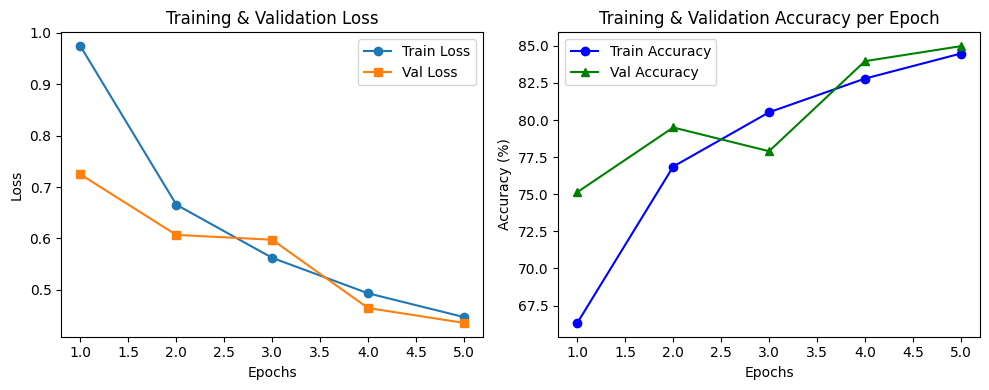

In [ ]:
# ----------------------------------------
# STEP 6 — TRAINING VISUALIZATION
# ----------------------------------------
plt.figure(figsize=(10,4))

# Plot 1: Loss
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label="Val Loss", marker='s')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot 2: Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy", marker='o', color='blue')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Val Accuracy", marker='^', color='green')
plt.title("Training & Validation Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


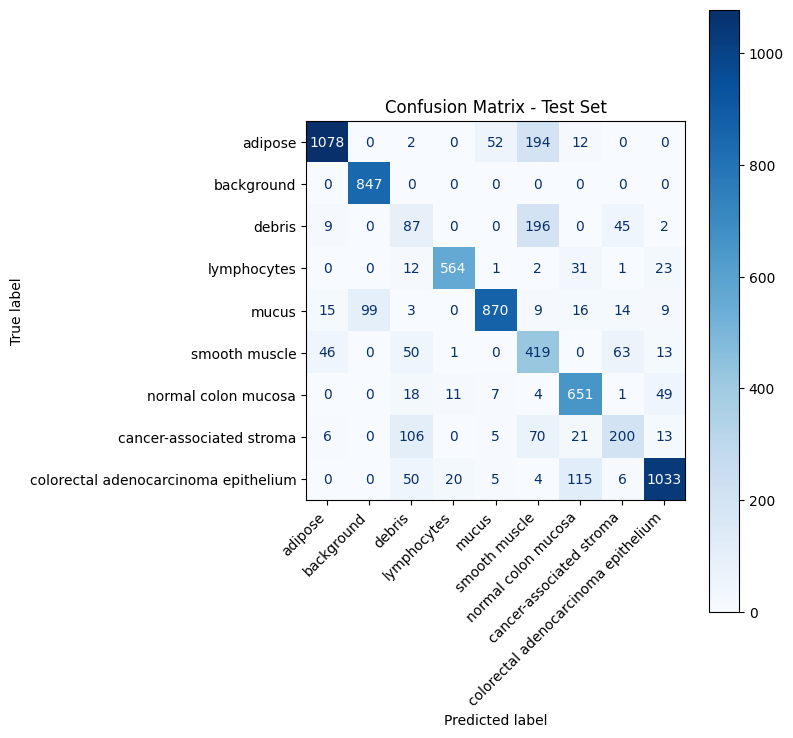


📊 Classification Report:
                                      precision    recall  f1-score   support

                             adipose     0.9341    0.8057    0.8652      1338
                          background     0.8953    1.0000    0.9448       847
                              debris     0.2652    0.2566    0.2609       339
                         lymphocytes     0.9463    0.8896    0.9171       634
                               mucus     0.9255    0.8406    0.8810      1035
                       smooth muscle     0.4666    0.7078    0.5624       592
                 normal colon mucosa     0.7695    0.8785    0.8204       741
            cancer-associated stroma     0.6061    0.4751    0.5326       421
colorectal adenocarcinoma epithelium     0.9046    0.8378    0.8699      1233

                            accuracy                         0.8007      7180
                           macro avg     0.7459    0.7435    0.7394      7180
                        weighted avg

In [ ]:
# ----------------------------------------
# STEP 7 — TEST PERFORMANCE ANALYSIS
# ----------------------------------------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix - Test Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))
